# Output analysis of inventory simulation model


This notepook is a tutorial on output analysis for a terminating simulation model. It uses the inventory simulation model in model.py.

Please check the README file for details on how the simulation conceptual model.

## Table of contents

1. [Using the simulation model](#using-model)
2. [Output analysis of a terminating simulation](#terminating-sim)  
    2.1 [Building a confidence interval for total inventory cost](#confidence-interval)  
    2.2 [Comparing alternative configurations](#compare-configs)  
3. [Minimizing inventory costs](#optim)  
    3.1 [Generating a contour plot](#contourplot)   
    3.2 [Generating a response surface](#responsesurface)  
    3.3 [Finding the optimum with a local search algorithm](#localsearch)
    

<a id="using-model"></a>
 
 ## 1. Using the simulation model

In [1]:
import numpy as np
import model

To run a single iteration of the inventory simulation model, use the run function of the model.py file. Users need to enter:

- a simulation length, expressed in months, after which the simulation stops. The default length is 120 days.
- a reorder point specifying the inventory level (in units) that triggers an order to replenish the stocks. 
- an order size specifying the number of units to order.

The function will return a dictionary containing user input parameters (reorder point, order size) and the model output (average monthly total inventory cost, ordering cost, shortage cost and holding cost).

Let us run a few iterations and have a look at their output:

In [6]:
# perform a single run of the inventory simulation model
model.run(reorder_point = 20, order_size = 20)

{'reorder_point': 20,
 'order_size': 20,
 'total_cost': 129.1,
 'ordering_cost': 103.0,
 'holding_cost': 8.9,
 'shortage_cost': 17.3}

In [8]:
# run alternative configuration of the model with increased order size
model.run(reorder_point = 20, order_size = 80)

{'reorder_point': 20,
 'order_size': 80,
 'total_cost': 125.6,
 'ordering_cost': 81.5,
 'holding_cost': 37.1,
 'shortage_cost': 7.1}

We have run two scenarios:
- In the both scenarios, an order is placed to replenish the inventory as soon as it gets below 20 units (reorder point of 20)
- In the first iteration, we place an order to replenish the inventory up to 40 units (reorder point + 20) whereas in the second iteration, we place an order to replenish the inventory up to 100 units (reorder point + 80).

This increase in order size results in higher average inventory costs, with the following breakdown:
- Lower shortage costs: larger orders are placed so shortages are less frequent
- Lower ordering costs: fewer orders are placed each months
- Higher holding costs: on average, a larger inventory is maintained.

We will now run an additional iteration, this time decreasing the reorder point to 10 units and maintaining an order size of 20 units above reorder point.

In [9]:
# run alternative configuration with smaller reorder point
model.run(reorder_point = 10, order_size = 20)

{'reorder_point': 10,
 'order_size': 20,
 'total_cost': 149.8,
 'ordering_cost': 99.6,
 'holding_cost': 4.3,
 'shortage_cost': 45.9}

In this configuration, the reorder point was lowered. This reduced the average holding costs (because a smaller inventory is being maintained) at the expense of a large increase in shortage cost.

This iteration is so far the worst of the three in terms of total costs.

<a id="terminating-sim"></a>

## 2. Output analysis of a terminating simulation

In this section, we will simulate an inventory system with a reorder point of 30 units and an order size of 60 units.

Since there is an event ending the simulation (after 120 months), the simulation will be analyzed as a terminating model (as opposed to analyzing steady state parameters for example).

> **Terminating and non-terminating simulations**
> A *terminating* simulation has a natural event that specifies the length of each run. This simulation is 'terminating' because we are interested in the output after 120 months.
> A *non-terminating* simulation has no such end-event and the analysis focuses on the long-term performance of the system.


In [10]:
# define simulation parameters
reorder_point = 30
order_size = 60

# run independent replications
first_run = model.run(reorder_point, order_size)
second_run = model.run(reorder_point, order_size)

# print results
print('First replication total costs:', first_run['total_cost'])
print('Second replication total costs:', second_run['total_cost'])

First replication total costs: 126.0
Second replication total costs: 125.8


The two independent replications of the model resulted in different total cost output, because of random variables embedded in the model. Demand sizes, time between demands and supplier lead times are random variates.

This means that a single run will not provide a definitive measure of total inventory cost. Instead, we can run several independent replications of the simulation to build a confidence interval for total inventory costs.

<a id="confidence-interval"></a>

### 2.1 Building a confidence interval for total inventory cost

Unless the simulation model is purely deterministic (i.e. there is no randomness in the model), it will be required to conduct a statistical analysis of the simulation output.

Running a single iteration of the simulation and reporting the performance measures is not a recommended approach. As we saw above, independent replications of a simulation will yield different output, which can result in poor decision making.

By doing several independent replications of each configurations allows to measure the spread of results and build a confidence interval for the average performance of the system. We will store the results of each replication in a pandas data frame.


In [11]:
import pandas as pd

length = 120.
num_replications = 15

df = pd.DataFrame(model.run_experiments([reorder_point], [order_size], num_replications))
df

,reorder_point,order_size,total_cost,ordering_cost,holding_cost,shortage_cost
0,30,60,127.4,88.5,34.5,4.4
1,30,60,122.6,83.8,35.9,2.9
2,30,60,127.0,87.3,36.9,2.9
3,30,60,121.5,82.5,36.4,2.6
4,30,60,124.0,84.8,36.3,2.9
5,30,60,127.8,89.0,34.5,4.2
6,30,60,124.0,84.3,37.0,2.7
7,30,60,121.8,83.1,35.8,2.9
8,30,60,123.2,84.8,34.8,3.6
9,30,60,123.7,84.2,37.2,2.2


We then need to compute our sample mean and sample standard deviation of the total cost output.

Because our sample size is small (less than 30 observations is often used as a rule of thumb), we'll use a t-statistics (as opposed to a z-statistics) to build our confidence interval.

In [13]:
from scipy import stats
 
# compute sample mean and standard deviation
mean = df['total_cost'].mean()
std = df['total_cost'].std()

# compute t-statistics for a 90% confidence interval
alpha = 1-.95
tstat = stats.t.ppf(1-alpha/2, num_replications - 1)

# compute confidence interval
error_margin = tstat * std / np.sqrt(num_replications)
lbound = mean - error_margin
ubound = mean + error_margin

print("90 percent confidence interval for monthly inventory cost: [%.1f, %.1f]" % (lbound, ubound))

90 percent confidence interval for monthly inventory cost: [123.5, 125.9]


It is a good practice to build confidence intervals whenever performance indicators need to be assessed; they add valuable information to the average. 
Assuming system A yields a performance of (100 +- 1) and B yields (100 +- 15), both systems performance is the same on average even though B is much riskier than A.

Although confidence intervals are not always easy to interpret, they communicate important information to simulation stakeholders and decision makers.

<a id="compare-configs"></a>
 
### 2.2 Comparing alternative configurations

In this subsection, we will compare the performance of two systems to determine which ones performs best. As said before, running a single replication of both systems is not a good practice as the response will be random and we risk making a poor decision.

There are several possible approaches to this problem. We're first going to run several independent replications of each system and then build a conference interval for the pairwise difference in total costs.

We're going to compare two configurations:
* Configuration 1: reorder point of 20, order size of 20
* Configuration 2: reorder point of 20, order size of 60

In [14]:
import numpy as np

num_rep = 30

# create arrays to store data
res_config1 = []
res_config2 = []

for i in range(num_rep):
    # run first configuration
    res = model.run(reorder_point = 20, order_size = 20)
    res_config1.append(res['total_cost'])

    # run second configuration
    res = model.run(reorder_point = 20, order_size = 60)
    res_config2.append(res['total_cost'])

# compute the average for each sample
avg_config1 = np.mean(res_config1)
avg_config2 = np.mean(res_config2)

print('Average monthly cost of (20,20):', round(avg_config1,2))
print('Average monthly cost of (20,60):', round(avg_config2,2))

Average monthly cost of (20,20): 123.95
Average monthly cost of (20,60): 121.78


We ran 30 independent replications to account for randomness in the model. The average cost of our second configuration is about 3% lower than the first configuration in our sample.

While this is practically significant, as it could result in substantial savings for a company, let us conduct a more robust analysis to ensure we're not observing a difference purely due to randomness.

Let us first visualize the data we have generated for both configurations.

C:\Users\luisalves\AppData\Local\Temp\ipykernel_18364\14866623.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['(20, 20)', '(20,60)'])


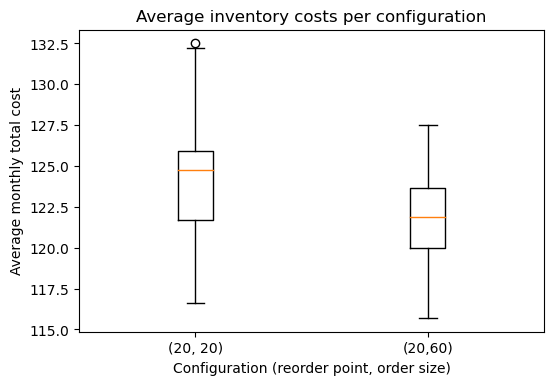

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

data = [res_config1, res_config2]

# create chart area
fig, ax = plt.subplots(dpi=100)
ax.set_xticklabels(['(20, 20)', '(20,60)'])
ax.set_title('Average inventory costs per configuration')
ax.set_xlabel('Configuration (reorder point, order size)')
ax.set_ylabel('Average monthly total cost')

# display boxplots
ax.boxplot(data)
plt.show()

Overall, costs from configuration #2 do seem to be lower than configuration #1. However, there is still a considerable overlap between the outputs of both systems.

Let us formulate two hypotheses:
- [H0] Null hypothesis: (cost of system 1 - cost of system 2) = 0
- [H1] Alternative hypothesis: (cost of system 1 - cost of system 2) <> 0

When we analyzed the performance of a single system, we built a confidence interval for the average monhtly cost. We are going to apply a similar approach to build a 90% confidence interval of the cost difference between both systems to see if 0 is included in the CI. If it is, it means we cannot reject the null hypothesis that both means are the same.

We are going to pair observations from both systems and substract the costs of each pair so that we can build a confidence interval for the difference.

In [16]:
from scipy import stats

# substract pairwise costs
data = [m - n for m,n in zip(res_config1, res_config2)]

# compute sample mean and standard deviation
mean = np.mean(data)
std = np.std(data, ddof = 1)

# compute t-statistics for a 90% confidence interval
alpha = 1-.9
tstat = stats.t.ppf(1-alpha/2, len(data) - 1)

# compute confidence interval
error_margin = tstat * std / np.sqrt(len(data))
lbound = mean - error_margin
ubound = mean + error_margin

print("90 percent confidence interval for cost difference: [%.1f, %.1f]" % (lbound, ubound))

90 percent confidence interval for cost difference: [0.5, 3.8]


The 90% CI for the cost difference does not include 0, this means that we can reject H0 and conclude that the average cost is significantly lower for configuration 2.

<a id="optim"></a>

## 3. Minimizing inventory costs

So far we have tested several configurations and built a confidence interval of their average cost output to determine which configuration is better.

In this section, we are going to explore the simulation model output to  determine the best combination of re-order point and order size that minimize the total monthly cost of the inventory system.

<a id="contourplot"></a>
### 3.1 Generating a contour plot

One way to find inputs combination that will optimize a response is to run several replications of the simulation model over a wide range of possible configuration and analyze each of the individual outputs.

You can run multiple configurations at once using the run_experiments function (see help below), or simply load the results.csv file that already contains the output dataset for the configurations we will specify in this section.

In [17]:
help(model.run_experiments)

Help on function run_experiments in module model:

run_experiments(reorder_points, order_sizes, num_rep)
    Runs inventory simulation with every combination of reorder points and
    order sizes, and assembles results in a list of dictionaries
    
    Args:
        - reorder_points: list of reorder points parameters to simulate 
        - order_sizes:list of order size parameters to simulate
        - num_rep: number of replications to run for each design point



We are going to run all configurations with reorder points going from 0 to 100 order sizes of 5 to 100 with increments of 5. Each configuration will be run 10 times.

In [18]:
# user inputs
num_rep = 10    # number of replications for each design point
reorder_points = np.arange(0,105,5)  # [0, 5, 10, ..., 95, 100]
order_sizes = np.arange(5,105,5)     # [5, 10, 15, ..., 95, 100]

# initialize results data collection
results = model.run_experiments(reorder_points, order_sizes, num_rep) # this may take a few minutes to run
results = pd.DataFrame(results)

Iteration 100 of 4200
Iteration 200 of 4200
Iteration 300 of 4200
Iteration 400 of 4200
Iteration 500 of 4200
Iteration 600 of 4200
Iteration 700 of 4200
Iteration 800 of 4200
Iteration 900 of 4200
Iteration 1000 of 4200
Iteration 1100 of 4200
Iteration 1200 of 4200
Iteration 1300 of 4200
Iteration 1400 of 4200
Iteration 1500 of 4200
Iteration 1600 of 4200
Iteration 1700 of 4200
Iteration 1800 of 4200
Iteration 1900 of 4200
Iteration 2000 of 4200
Iteration 2100 of 4200
Iteration 2200 of 4200
Iteration 2300 of 4200
Iteration 2400 of 4200
Iteration 2500 of 4200
Iteration 2600 of 4200
Iteration 2700 of 4200
Iteration 2800 of 4200
Iteration 2900 of 4200
Iteration 3000 of 4200
Iteration 3100 of 4200
Iteration 3200 of 4200
Iteration 3300 of 4200
Iteration 3400 of 4200
Iteration 3500 of 4200
Iteration 3600 of 4200
Iteration 3700 of 4200
Iteration 3800 of 4200
Iteration 3900 of 4200
Iteration 4000 of 4200
Iteration 4100 of 4200
Iteration 4200 of 4200


In [19]:
import pandas as pd
# load dataset as a data frame
results = pd.read_csv('results.csv')

# select relevant columns
data = results[['order_size', 'reorder_point', 'total_cost']]

# for each combination of order size and reorder point, compute average response
data = data.groupby(['reorder_point', 'order_size']).mean()

# reset data index and rename columns
data.reset_index(inplace = True)
data.columns = ['reorder_point', 'order_size', 'cost']

# pivot dataset
data = data.pivot('reorder_point', 'order_size')

In [20]:
# map values
X = data.columns.levels[1].values  # order sizes
Y = data.index.values # reorder points
Z = data.values # average total cost
Xi, Yi = np.meshgrid(X,Y)

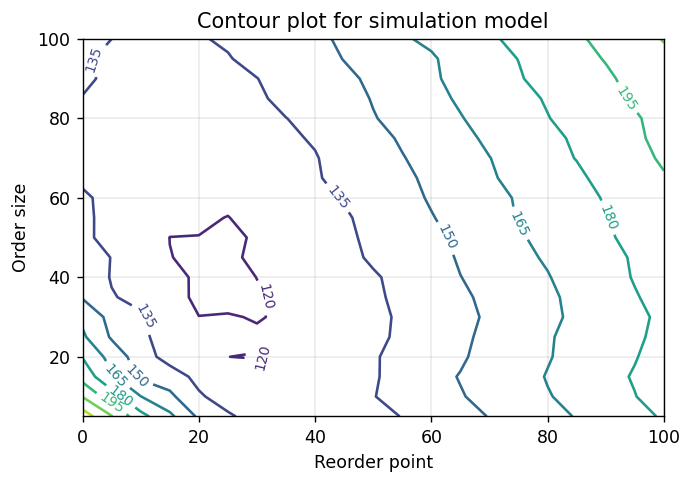

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# generate contour plot
plt.figure(dpi=125)
plt.title('Contour plot for simulation model')
plt.xlabel('Reorder point')
plt.ylabel('Order size')

contours = plt.contour(Yi, Xi, Z, 10)
plt.clabel(contours, inline=True, fmt='%1.0f', fontsize=8)
plt.grid(color='gray', linestyle='-', linewidth=.15)

plt.show()


The contour plot shows us the expected average monthly total cost for each combination of order size and reorder point.

It seems that the minimum cost of the inventory system is between 110 and 120. It is reached when the order size is approximately 40 units and the reorder point around 30.

As we increase the reorder point and order size, the cost of the system rises steadily, due to greater holding costs. In the opposite corner, lowering the reorder point and order sizes creates a dramatic increase in total cost, due to frequent shortage of items.

<a id="responsesurface"></a>
### 3.2 Generating a response surface

The output of the simulation model can also be visualized as a 3D response surface. It really is a matter of personal preference. Let's use the same dataset and create a new visualization.

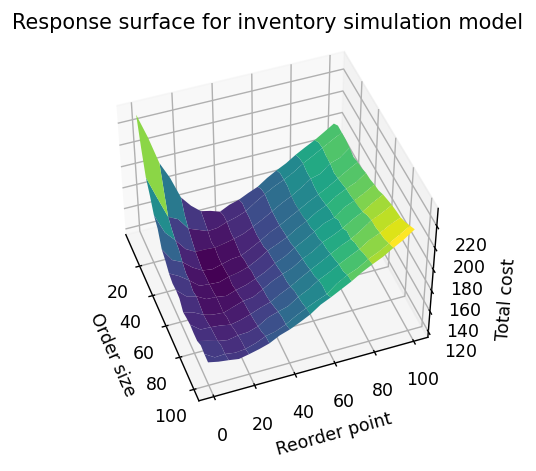

In [22]:
from mpl_toolkits import mplot3d

# generate response surface
fig = plt.figure(dpi = 125)
ax = plt.axes(projection='3d')
ax.plot_surface(Xi, Yi, Z, 
                rstride=2 , cstride=2,
                cmap='viridis', edgecolor = 'none')
ax.set_title('Response surface for inventory simulation model')
ax.set_xlabel('Order size')
ax.set_ylabel('Reorder point')
ax.set_zlabel('Total cost')
ax.view_init(45, -20)

<a id="localsearch"></a>
### 3.3 Finding the optimum with a local search algorithm

In the previous sections, we have generated a contour plot to identify the set of inputs that would minimize our inventory costs. This approach gave us a lot of information about the simulation response, but it required running 20 * 19 = 480 design points with 10 iterations over each design point, resulting in 4,800 simulation runs.

This is still manageable in this scenario because the search space is rather small with only two input variables and a reasonably narrow range of values for each. Should we add other variables (or a much more complex model), this methodology would quickly become impractical.

Instead we are only going to explore a subset of the search space thanks to a local search algorithm. The algorithm will explore design points close to its starting position and select a neighbor if it improves the current cost. This step will be repeated a fixed number of times in order to find a (hopefully) close to optimal solution.


In [23]:
import optim

# run the algorithm with 3 different starting points
a = optim.LocalSearch([90,90], 20, 8)
b = optim.LocalSearch([90,10], 20, 8)
c = optim.LocalSearch([20,80], 20, 8)

print(a.path)

[[ 90.          90.        ]
 [ 75.04129983 100.        ]
 [ 75.78212699  93.8792046 ]
 [ 62.27155813  74.30066321]
 [ 59.53558464  65.61902767]
 [ 58.26326802  57.10511285]
 [ 49.39394992  66.37419586]
 [ 40.59623788  82.75585288]
 [ 34.50390086  93.40350425]
 [ 37.62683532  78.13497313]
 [ 34.57124007  74.90591836]]


The local search class in optim.py stores the explored design points in its path variable and the associated objective function value in its cost variable.

Let's visualize the path explored by each repetition of the algorithm by using the contour plot we created earlier.

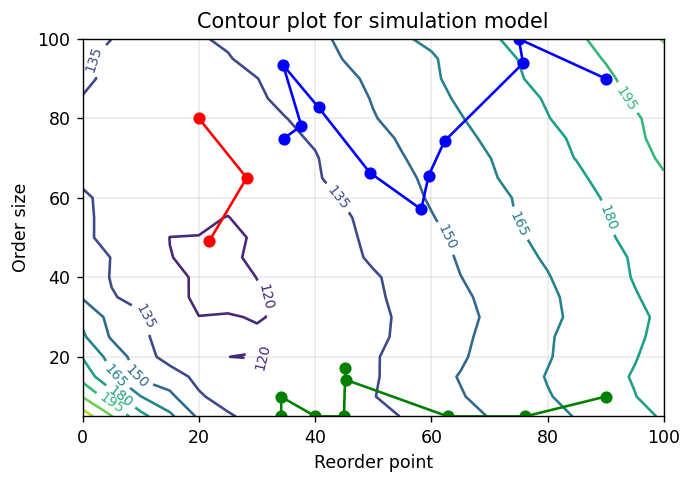

In [24]:
# re-create contour plot
plt.figure(dpi=125)
plt.title('Contour plot for simulation model')
plt.xlabel('Reorder point')
plt.ylabel('Order size')
contours = plt.contour(Yi, Xi, Z, 10)
plt.clabel(contours, inline=True, fmt='%1.0f', fontsize=8)
plt.grid(color='gray', linestyle='-', linewidth=.15)

# add lines to visualize algorithms path
plt.plot(a.path[:,0],a.path[:,1],'b-o')
plt.plot(b.path[:,0],b.path[:,1],'g-o')
plt.plot(c.path[:,0],c.path[:,1],'r-o')
plt.show()


The chart above shows that regardless the starting point, each iterations manages to move towards the optimmum solution and reach an average monthly cost of approximately 120.

The local search algorithm used here is simple and only yields good results because there is a single local minimum in the solution space. For more complex problems, more advanced algorithms (e.g. simulated annealing, genetic algorithms...) are usually required to find the global optimum.